In [1]:
% hybrid: first obtain solution from IRN. Then run Bayes to refine the result
% IRN: automatic calculation of mu
clear;
close all;

## load data

In [2]:
% inputname1 = './single_qsource/steady_3d_conduction_convection_turb_v1_single_qsource_rectangle_G4215_0852kW.mat';
inputname1 = './single_qsource/steady_3d_conduction_convection_turb_v1_single_qsource_halfcross_G4215_0852kW.mat';
% inputname1 = './single_qsource/steady_3d_conduction_convection_turb_v1_single_qsource_arc1_G4215_0852kW.mat';
% inputname1 = './single_qsource/steady_3d_conduction_convection_turb_v1_single_qsource_groove1_G4215_0852kW.mat';
load(inputname1,'z_grid_mm','y_grid_mm','k_cond', 'dx', 'N_z','N_y','T_2d_interface','T_inlet_uniform','q_source','IT_conversion_A_div_I_conversion','I_conversion','vertices');

% interface to qbcs
q_source_qbcs = q_source(2:end, :);
q_source_qbcs_flatten = q_source_qbcs(:);
x_true = q_source_qbcs_flatten*-dx/k_cond;
N_qbcs = length(q_source_qbcs_flatten);
heat_flux_source = max(q_source_qbcs_flatten);

## sensor array generation

In [3]:
% sensor distance 1
% input_z = [2:101];
% input_y = [1:19];
% sensor distance 2
% input_z = [2:2:100];
% input_y = [1:2:19];
% sensor distance 3 (Simulation)
input_z = [2:3:101];
input_y = [1:3:19];
% sensor distance 3 (Experiment)
% input_z = [19:3:84];
% input_y = [11:-3:1];
% sensor distance 4
% input_z = [2:4:98];
% input_y = [1:4:17];
% sensor distance 5
% input_z = [2:5:97];
% input_y = [1:5:16];
% sensor distance 6
% input_z = [2:6:98];
% input_y = [1:6:19];

## assign and produce sensor index

In [4]:
N_x_1 = 300+1; % liquid grid points (including both ends) in x-direction
sensor_user_input = zeros(length(input_z)*length(input_y), 3);
sensor_user_input(:,2) = N_x_1; % at solid-liquid interface
for iz=1:length(input_z)
    for iy=1:length(input_y)
        row = (iz-1)*length(input_y) + iy;
        sensor_user_input(row, 1) = input_z(iz);
        sensor_user_input(row, 3) = input_y(iy);
    end
end

sensor_index_z = sensor_user_input(:,1);
sensor_index_x = sensor_user_input(:,2);
sensor_index_y = sensor_user_input(:,3);
sensor_index_qbcs = (sensor_index_z-1) + (sensor_index_y-1)*(N_z-1); % indexing within qbcs
number_sensor = length(sensor_index_z);

Phi_location_sensor_qbcs = sparse(number_sensor, (N_z-1)*N_y); % sensor at qbcs grid
T_sensing = zeros(number_sensor,1); % [K] column vector for temperature measurements
for ids=1:size(sensor_index_qbcs, 1)
    Phi_location_sensor_qbcs(ids, sensor_index_qbcs(ids)) = 1;
    T_sensing(ids) = T_2d_interface(sensor_index_z(ids), sensor_index_y(ids));
end

## generate artificial noise

In [5]:
rng('default') % rng(1)
noise_magnitude = 0.5; % [Kelvin] INPUT
fprintf('artificial noise magnitude [K]: %.2f \n', noise_magnitude);

artificial noise magnitude [K]: 0.50

In [6]:
T_sensing = T_sensing + noise_magnitude*randn(number_sensor, 1); % add artifical noise

## gradient operator

In [7]:
Dz = zeros((N_z-1)*N_y, (N_z-1)*N_y);
matrix_idr = repmat([2:N_z-1]',1,N_y) + repmat((N_z-1)*(0:N_y-1),N_z-2,1);
column_idr = matrix_idr(:);
column_idc_diag = column_idr;
vector_id_diag = column_idr + N_y*(N_z-1)*(column_idc_diag - 1);
column_idc_offdiag = column_idr-1;
vector_id_offdiag = column_idr + N_y*(N_z-1)*(column_idc_offdiag - 1);
Dz(vector_id_diag) = 1;
Dz(vector_id_offdiag) = -1;

Dy = zeros((N_z-1)*N_y, (N_z-1)*N_y);
column_idr = N_z:N_y*(N_z-1);
column_idc_diag = column_idr;
vector_id_diag = column_idr + N_y*(N_z-1)*(column_idc_diag - 1);
column_idr = N_z:(N_y)*(N_z-1);
column_idc_offdiag = column_idr - (N_z-1);
vector_id_offdiag = column_idr + N_y*(N_z-1)*(column_idc_offdiag - 1);
Dy(vector_id_diag) = 1;
Dy(vector_id_offdiag) = -1;

% difference in z and y direction
Dzy = [Dz; Dy]; % into one operation

## input for IRN iteration

In [8]:
A = full(Phi_location_sensor_qbcs*IT_conversion_A_div_I_conversion);
b = T_sensing - T_inlet_uniform;
L = Dzy;
pnorm = 2; % INPUT
qnorm = 0.1; %  INPUT
n_iter = 50; %  INPUT maximum number of iteration
mu = 0.1; % INPUT initial condition (e.g., 0.1403)
epsilon_F = 10^-3;
epsilon_R = 10^-3;
n_re_initialize = 2;

m = size(A, 1); % number of measurement
n = size(A, 2); % number of unknown

## Initializations

In [9]:
mu0 = mu;
x0 = (A'*A + mu0*L'*L)\(A'*b);
x = x0;
wf = zeros();

residual_x0 = norm(A*x0-b, pnorm)^pnorm;
relative_error_x0 = norm(x0 - x_true)/norm(x_true);
Lqq_x0 = norm(L*x0, qnorm)^qnorm;
cost_function_x0 = 1/pnorm*residual_x0 + mu/qnorm*Lqq_x0;
qbcs_x0 = x0*-k_cond/(1*dx); % adjust unit to recover heat flux [W/m2]
qbcs_2d_x0 = reshape(qbcs_x0, [N_z-1, N_y]); % 2d profile
L0_x0 = nnz(abs(L*qbcs_x0) >= max(L*qbcs_x0)*0.05);

## iteration history to save

In [10]:
x_history = {}; % check the difference betwen {} and []
mu_history = [];
residual_history = [];
relative_error_history =[];
cost_function_history = [];
L0_history = [];
Lqq_history = zeros(1, length(x_history));
convergence_check_history = [];

## IRN iteration

In [11]:
for ii = 1:n_iter

## weighting matrix

In [12]:
    v = A*x - b;
    wf = smoothed_holder_weights(v, epsilon_F, pnorm);
    u = L * x;
    wr = smoothed_holder_weights(u, epsilon_R, qnorm);

## solve normal equation: convex optimization problem

In [13]:
    AW12 = A .* sqrt(wf);     % Step 1: Element-wise multiplication of each row of A by w, newer MATLAB syntax (=W_F*A)
    LW12 = L .* sqrt(wr);
    T = AW12' * AW12 + mu* LW12' * LW12;
    Wb = b .* wf; % Step 1: Element-wise multiplication of b by W
    rhs = A' * Wb; % Step 2: Multiply the result by A^T
    x = T\rhs; % solve normal equation

## save result

In [14]:
    x_history{end+1} = x; % Store current solution
    Lqq_history(ii) = norm(L*x, qnorm)^qnorm;

    x_diff = x - x_true;
    residual_history(end + 1) = norm(A*x-b, pnorm)^pnorm;
    cost_function_history(end + 1) = 1/pnorm*residual_history(end) + mu/qnorm*Lqq_history(ii);
    relative_error_history(end + 1) = norm(x_diff)/norm(x_true);

    qbcs_x = x*-k_cond/(1*dx); % recover heat source flux [W/m2]
    gradient_check_zy = L*qbcs_x;
    L0_history(end + 1) = nnz(abs(gradient_check_zy) >= max(gradient_check_zy)*0.05);

    mu_history(end+1) = mu;

## next iteration

In [15]:
    mu = n*qnorm/Lqq_history(ii);

    if ii>1
        convergence_check_history(ii) = norm(x_history{end}-x_history{end-1})/norm(x_history{end});
        if convergence_check_history(ii) <= 10^-5
        fprintf('iteration %d (over %d), x converged. μ = (%.2e)\n', ii, n_iter, mu);
        break;
        end
    end

    % re-initialize x for guarantee convergence with any mu0
    if ii == n_re_initialize
        fprintf('iteration %d, re-initialize x. \n', ii);
        x = (A'*A + mu*L'*L)\(A'*b);
    end

end

iteration 2, re-initialize x. 
iteration 25 (over 50), x converged. μ = (1.43e-01)

## heat flux distribution

In [16]:
qbcs_2d_IRN = reshape(x, [N_z-1, N_y])*-k_cond/dx; %

## estimation of noise

In [17]:
noise_estimation = sqrt(residual_history(end)/number_sensor);
fprintf('Estimated noise magnitude [K]: %.2f\n', noise_estimation); %

Estimated noise magnitude [K]: 0.48

## IRN to Bayes

In [18]:
variance_T = noise_estimation^2;
theta = x; % change variable

abs_Dzy_theta = abs(Dzy*theta); % edge distribution
threshold_ratio = 0.5; % INPUT for MRF line process
threshold = prctile(abs_Dzy_theta, 99)*threshold_ratio; % use percentile to avoid sensitivity to peak value

## MRF prior function

In [19]:
W_adaptive = zeros((N_z-1)*N_y, (N_z-1)*N_y);
for i_qbcs=1:N_qbcs

## assign values

In [20]:
    idz_qbcs = rem(i_qbcs-1, N_z-1)+1; % i-1 then +1 for consistency at the rightmost point (N_z-1)
    idy_qbcs = (i_qbcs-idz_qbcs)/(N_z-1) + 1;

    neighbors = []; % Collect neighbor indices
    if idz_qbcs > 1 % Left neighbor
        neighbors(end+1) = (idz_qbcs-1) + (idy_qbcs - 1)*(N_z-1);
    end
    if idz_qbcs < (N_z-1) % Right neighbor
        neighbors(end+1) = (idz_qbcs+1) + (idy_qbcs - 1)*(N_z-1);
    end
    if idy_qbcs > 1 % Upper neighbor
        neighbors(end+1) = (idz_qbcs) + (idy_qbcs - 1 - 1)*(N_z-1);
    end
    if idy_qbcs < N_y % Lower neighbor
        neighbors(end+1) = (idz_qbcs) + (idy_qbcs + 1 - 1)*(N_z-1);
    end

    for j_qbcs=neighbors
        eta = theta(i_qbcs) - theta(j_qbcs); % difference between pixel
        h = MRF_line_process(eta, threshold); % line process interaction function
        W_adaptive(i_qbcs, i_qbcs) = W_adaptive(i_qbcs, i_qbcs) + h;
        W_adaptive(i_qbcs, j_qbcs) = - h;
    end
end

## derived Bayes hyperparameter

In [21]:
lambda_const = N_qbcs/(theta'*W_adaptive*theta); % value for start

## Bayes iteration setting

In [22]:
M_repetition = 200; % INPUT
theta_save = zeros(N_qbcs, M_repetition);

## compute before iteration

In [23]:
inputname2 = './all_pointsources_allqbcs/all_pointsources_allqbcs_G4215.mat';
load(inputname2,'T_qbcs_allqbcs'); % N_qbcs(grid)*N_qbcs matrix(point heat source), for construction of H matrix
H = T_qbcs_allqbcs(sensor_index_qbcs, :)*-k_cond/dx;
H_dot_H = H.*H;
sum_H_dot_H = sum(H_dot_H, 1); % for 'a' in gibbs sampling

## Gibbs sampling iteration

In [24]:
fprintf('start Bayes calculation (total %d)\n', M_repetition)

start Bayes calculation (total 200)

In [25]:
for m=1:M_repetition
    if rem(m, 100) == 0 % every 100 iteration
        fprintf('rep: %d (total %d)\n', m, M_repetition)
    end

    for i_qbcs=1:N_qbcs

rep: 100 (total 200)
rep: 200 (total 200)

## update 'W\_adaptive'

In [26]:
    idz_qbcs = rem(i_qbcs-1, N_z-1)+1; % i-1 then +1 for consistency at the rightmost point (N_z-1)
    idy_qbcs = (i_qbcs-idz_qbcs)/(N_z-1) + 1;

    neighbors = []; % Collect neighbor indices
    if idz_qbcs > 1 % Left neighbor
        neighbors(end+1) = (idz_qbcs-1) + (idy_qbcs - 1)*(N_z-1);
    end
    if idz_qbcs < (N_z-1) % Right neighbor
        neighbors(end+1) = (idz_qbcs+1) + (idy_qbcs - 1)*(N_z-1);
    end
    if idy_qbcs > 1 % Upper neighbor
        neighbors(end+1) = (idz_qbcs) + (idy_qbcs - 1 - 1)*(N_z-1);
    end
    if idy_qbcs < N_y % Lower neighbor
        neighbors(end+1) = (idz_qbcs) + (idy_qbcs + 1 - 1)*(N_z-1);
    end

    W_adaptive(i_qbcs, i_qbcs) = 0; % initialization
    for j_qbcs=neighbors
        W_adaptive(i_qbcs, j_qbcs) = 0; % initialization

        eta = theta(i_qbcs) - theta(j_qbcs);
        h = MRF_line_process(eta, threshold);

        W_adaptive(i_qbcs, i_qbcs) = W_adaptive(i_qbcs, i_qbcs) + h;
        W_adaptive(i_qbcs, j_qbcs) = - h;
    end

## Gibbs sampler

In [27]:
    a = sum_H_dot_H(i_qbcs)/variance_T + lambda_const*W_adaptive(i_qbcs, i_qbcs);
    b_temp1 = dot(W_adaptive(i_qbcs,:)', theta) + dot(W_adaptive(:,i_qbcs), theta) - 2*W_adaptive(i_qbcs, i_qbcs)*theta(i_qbcs);
    HT_H_theta = H'*(H*theta);
    b_temp2 = dot((T_sensing - T_inlet_uniform), H(:, i_qbcs)) - ( HT_H_theta(i_qbcs) - dot(H(:,i_qbcs), H(:,i_qbcs))*theta(i_qbcs) );
    b = lambda_const*b_temp1 - 2/variance_T*b_temp2;

    mu_i = -b/(2*a);
    sigma_i = 1/sqrt(a);
    theta(i_qbcs) = normrnd(mu_i, sigma_i);
    end

## save result

In [28]:
    theta_save(:,m) = theta;
end

## averaged result from iterations

In [29]:
result_start = M_repetition/2;
result_end = M_repetition;

qbcs_result = mean(theta_save(:, result_start:result_end), 2)*-k_cond/dx;
qbcs_result_2d = reshape(qbcs_result, [N_z-1, N_y]); % for display heat flux

qbcs_result_statistics = qbcs_result;
qbcs_result_statistics = qbcs_result_statistics(qbcs_result_statistics > 0.8*heat_flux_source);
qbcs_result_statistics_mean = mean(qbcs_result_statistics);
qbcs_result_statistics_std = std(qbcs_result_statistics);

## plot results

In [30]:
m_plot = M_repetition;
fontsize = 14;

% Create a new figure
figure;
set(gcf, 'WindowState', 'maximized');
cmax = max(theta_save(:,m_plot)*-k_cond/dx, [],'all');

## initial IRN solution


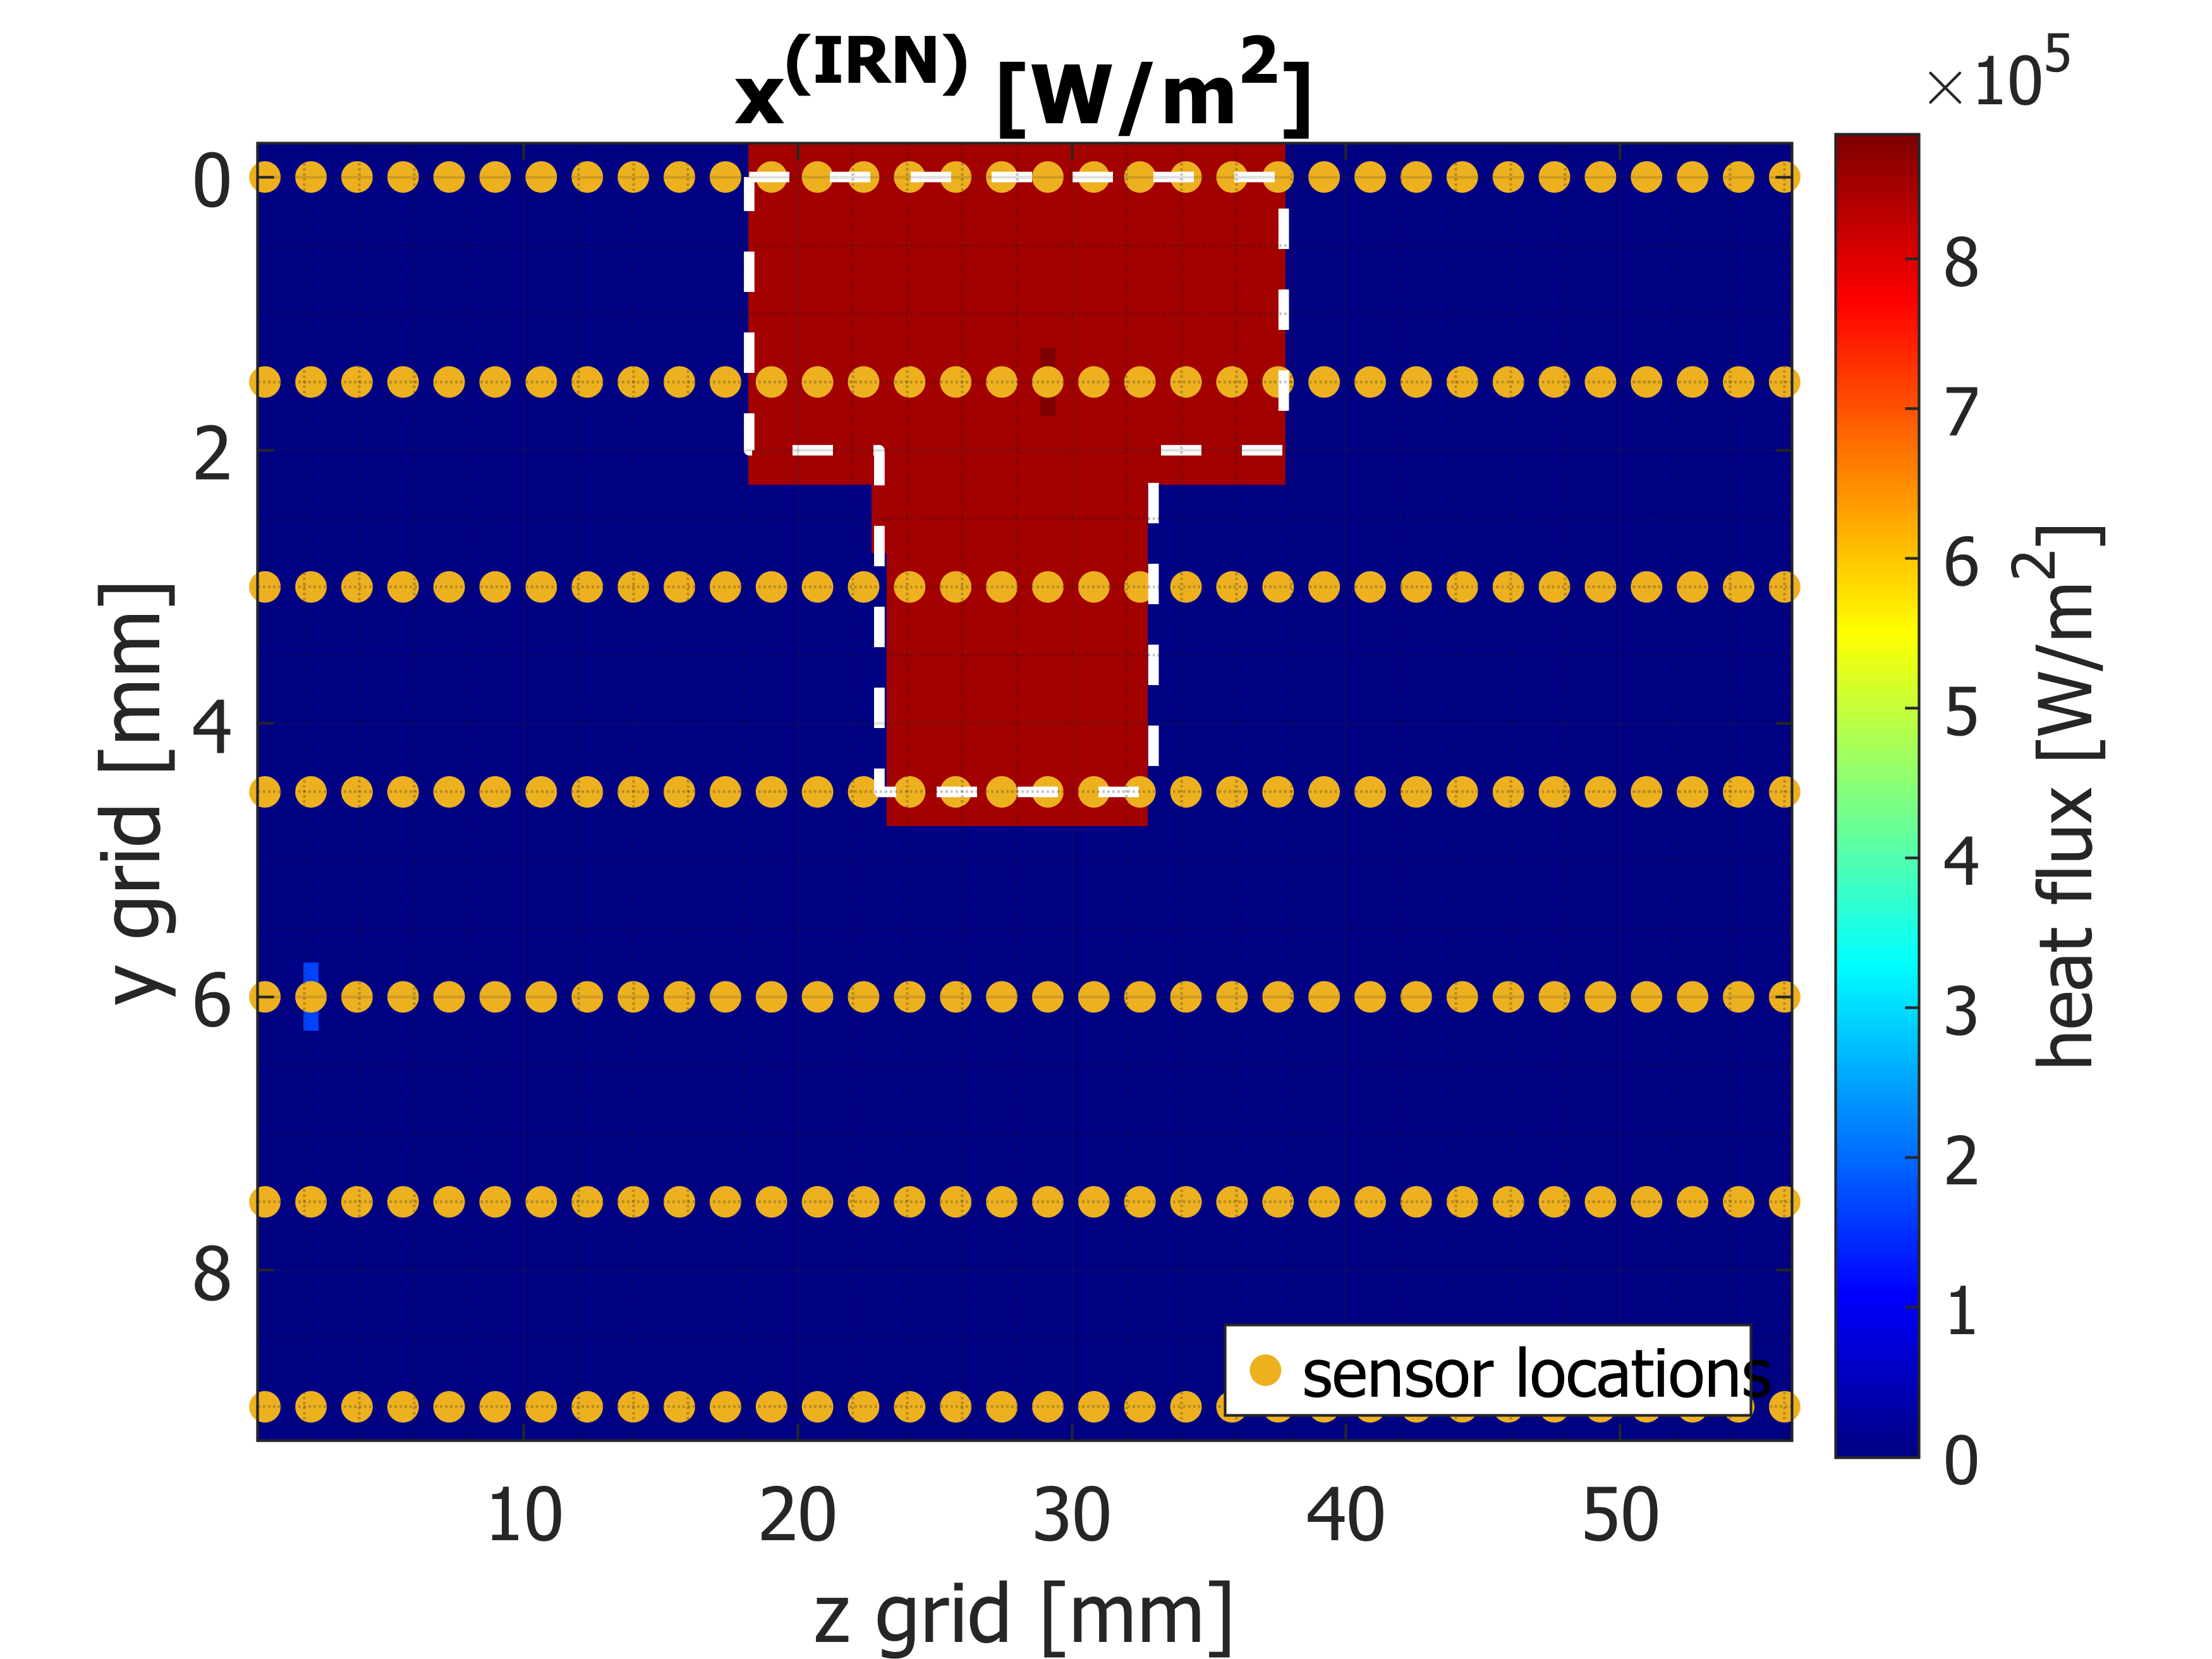

In [31]:
% subplot(2,2,1)
imagesc(z_grid_mm(2:end), y_grid_mm, qbcs_2d_IRN')
hold on
scatter(z_grid_mm(sensor_index_z), y_grid_mm(sensor_index_y),'filled','displayname','sensor locations','MarkerFaceColor','#EDB120')
hold on;
plot(vertices(:,1)*1000, vertices(:,2)*1000, '--','LineWidth', 2,'color','#FFFFFF','handlevisibility','off'); % Plot polygon lines on top, converting meters to mm
colormap('jet');
c = colorbar; % Get the handle of the colorbar
ylabel(c, 'heat flux [W/m^2]','fontname','times','FontSize',fontsize)
caxis([0 cmax])
xlabel('z grid [mm]')
ylabel('y grid [mm]')
legend('show','location','southeast')
titleStr = sprintf('x^{(IRN)} [W/m^2]');
title(titleStr);
set(gca,'FontSize',fontsize,'fontname','times')
grid on
grid minor

## Bayes chain history at selected grid


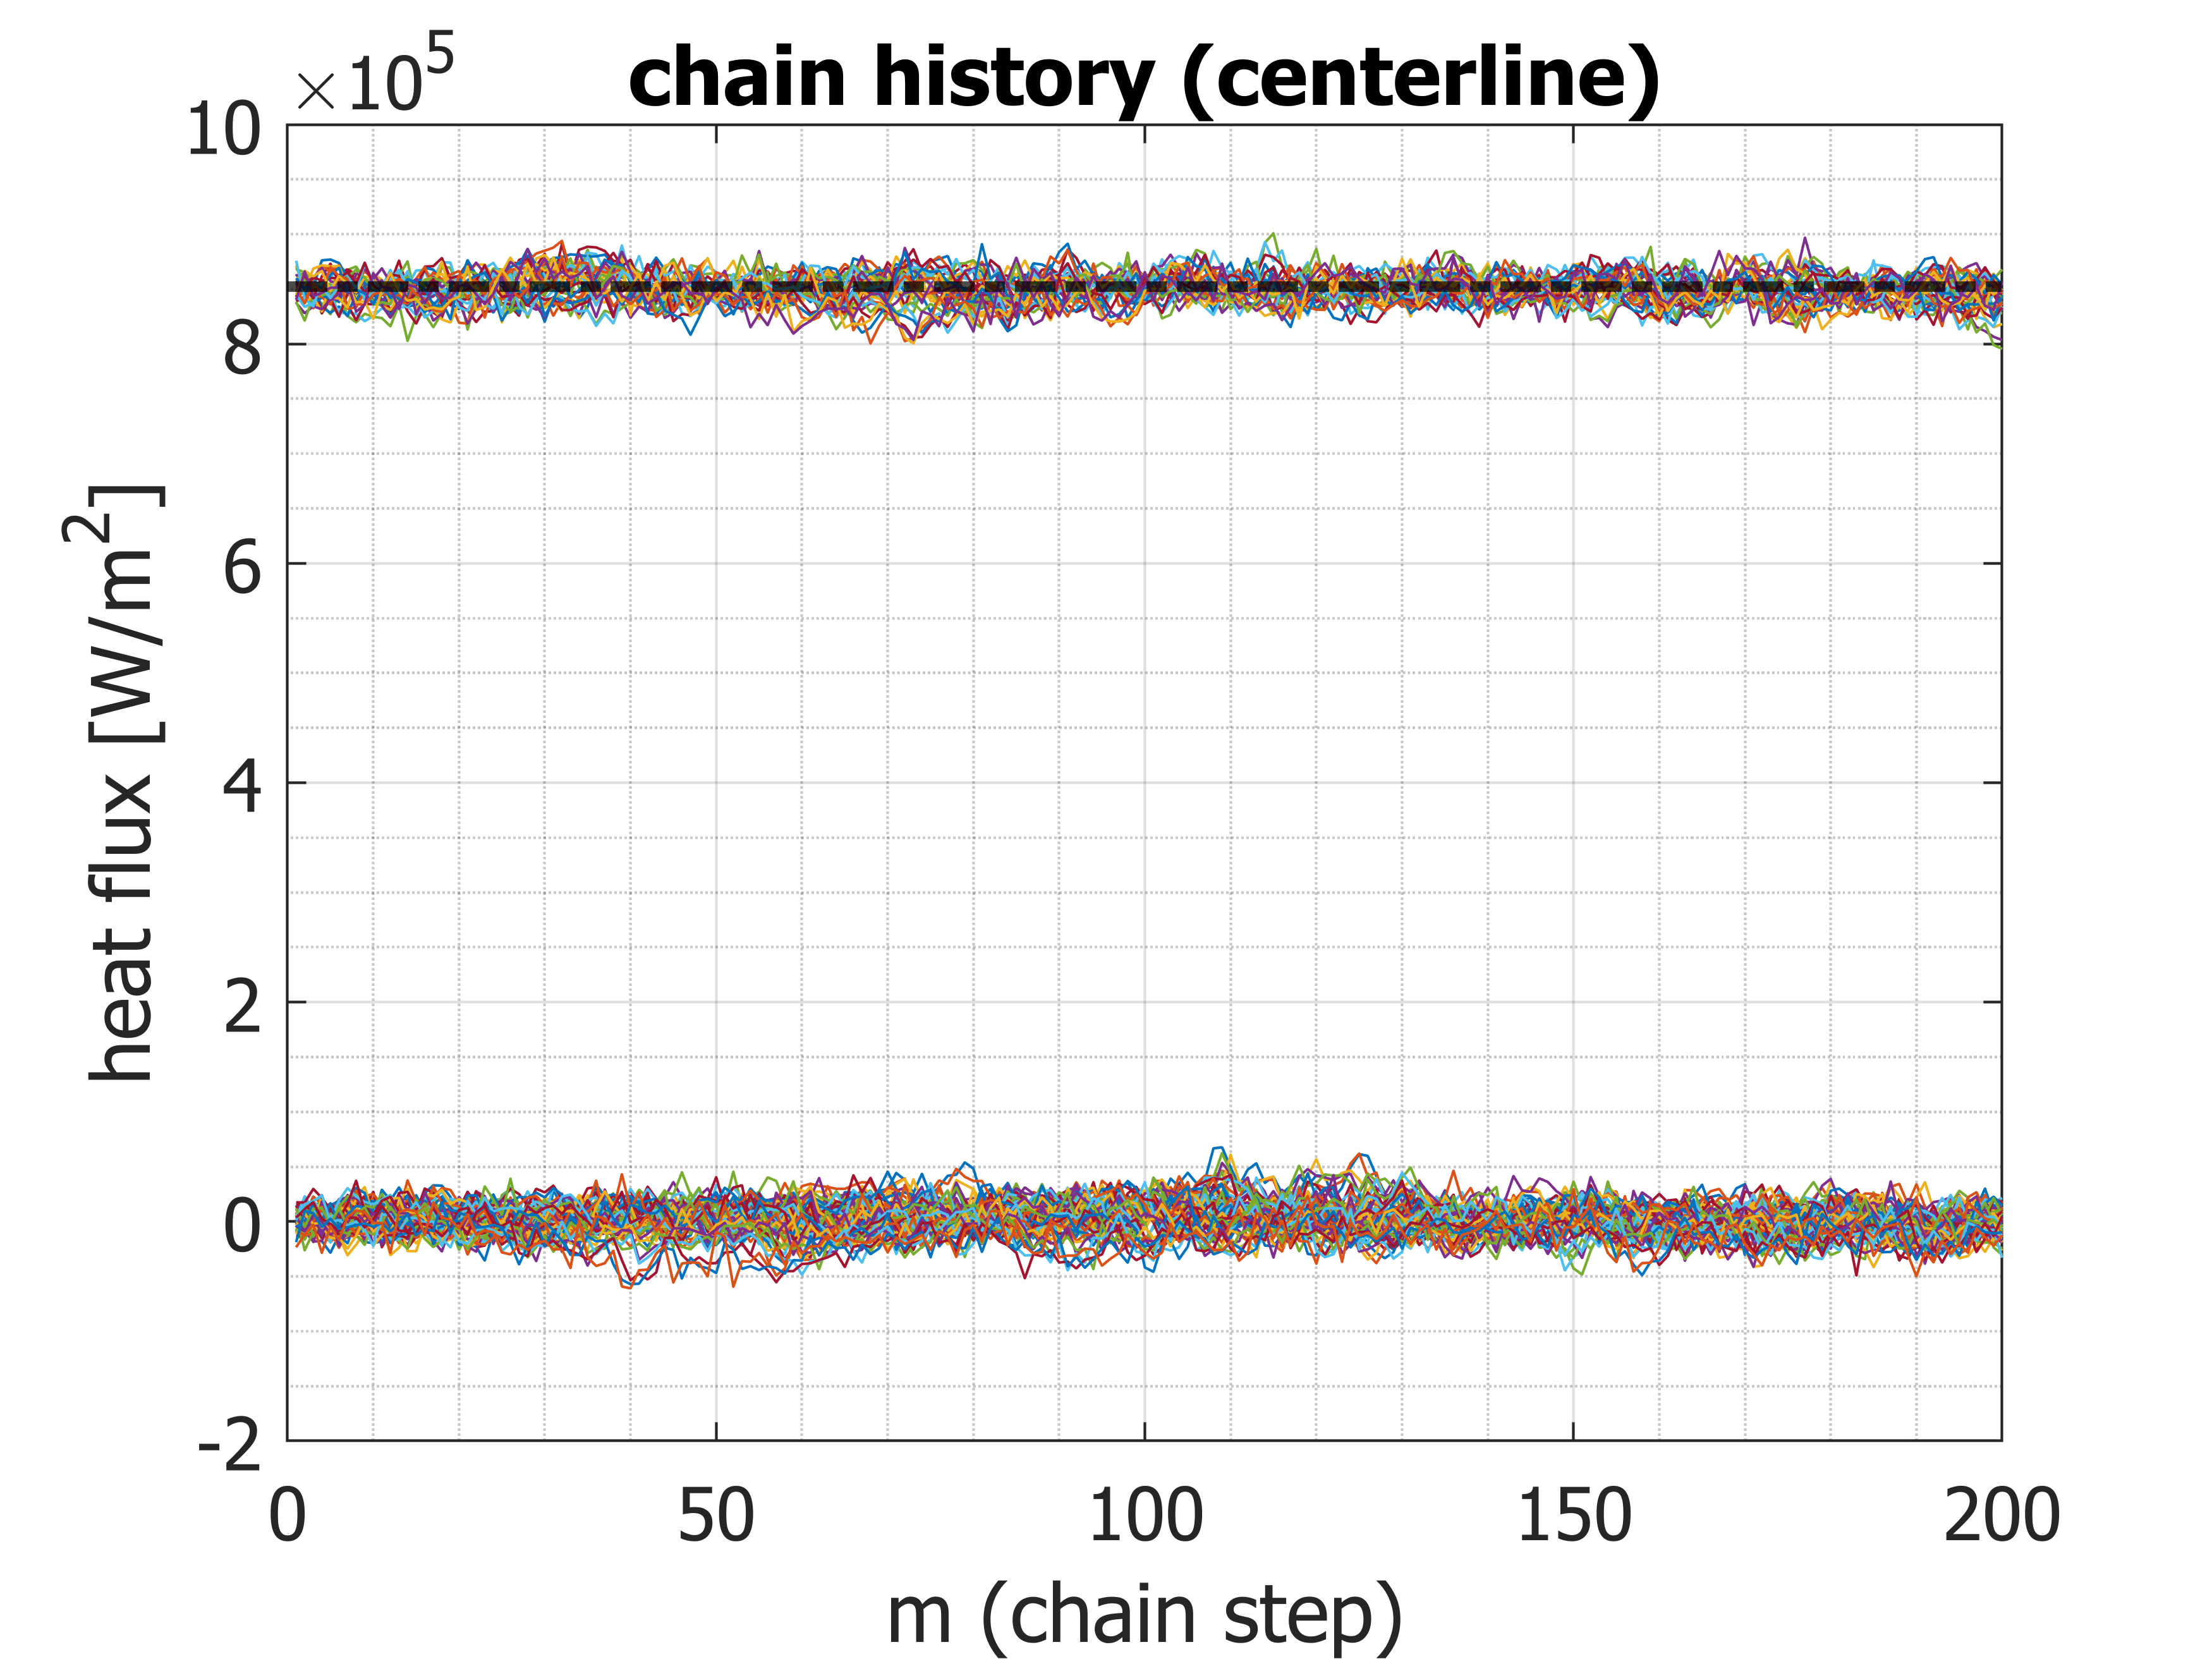

In [32]:
idx_chains = [1:100]; % grid index
figure;
set(gcf, 'WindowState', 'maximized');
plot(1:M_repetition, theta_save(idx_chains, 1:M_repetition)'*-k_cond/(1*dx))
hold on
yline(heat_flux_source,'-.k','Linewidth',2)
xlabel('m (chain step)')
ylabel('heat flux [W/m^2]')
title('chain history (centerline)')
set(gca,'FontSize',fontsize,'fontname','times')
grid on
grid minor

## Bayes result


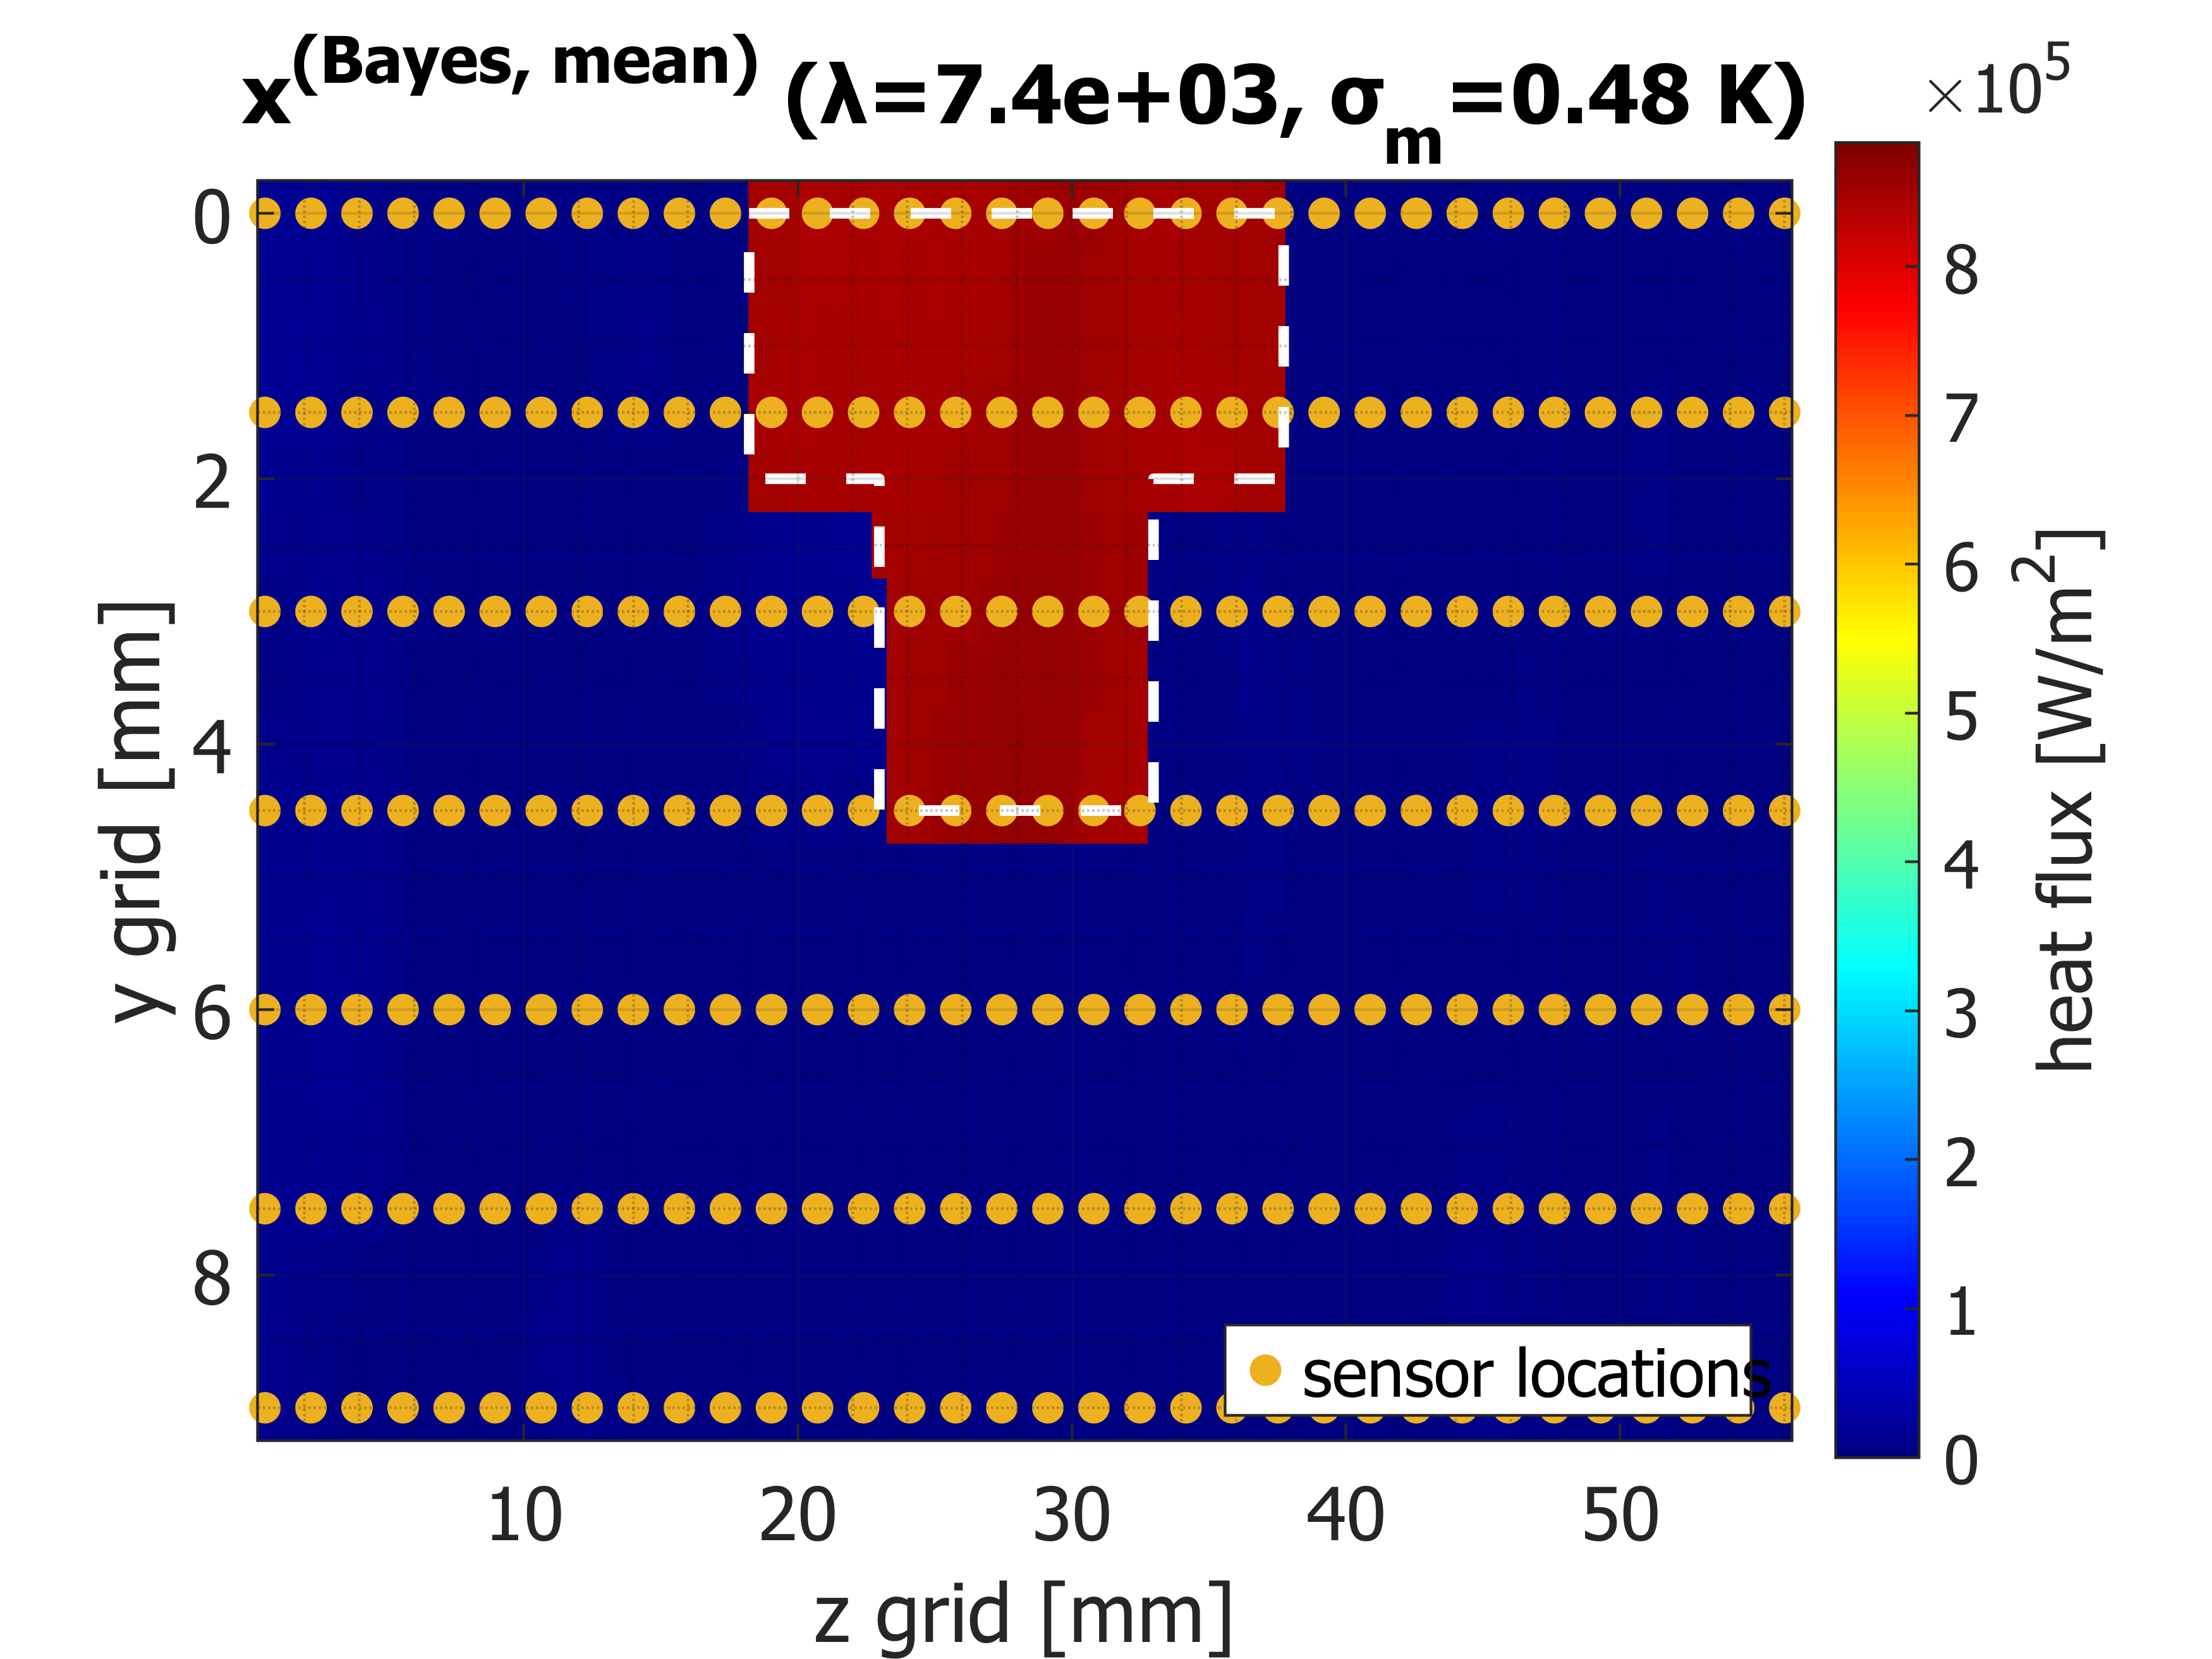

In [33]:
figure;
set(gcf, 'WindowState', 'maximized');
imagesc(z_grid_mm(2:end), y_grid_mm, qbcs_result_2d')
hold on
scatter(z_grid_mm(sensor_index_z), y_grid_mm(sensor_index_y),'filled','displayname','sensor locations','MarkerFaceColor','#EDB120')
hold on; % Retain the current plot when adding new plots
plot(vertices(:,1)*1000, vertices(:,2)*1000, '--','LineWidth', 2,'color','#FFFFFF','handlevisibility','off'); % Plot polygon lines on top, converting meters to mm
colormap('jet');
c = colorbar; % Get the handle of the colorbar
ylabel(c, 'heat flux [W/m^2]','fontname','times','FontSize',fontsize)
caxis([0 cmax])
xlabel('z grid [mm]')
ylabel('y grid [mm]')
legend('show','location','southeast')
titleStr = sprintf('x^{(Bayes, mean)} (λ=%.1e, σ_m=%1.2f K)', lambda_const, sqrt(variance_T));
title(titleStr);
set(gca,'FontSize',fontsize,'fontname','times')
grid on
grid minor


## Bayes result statistics

Define the range for histogram bin edges



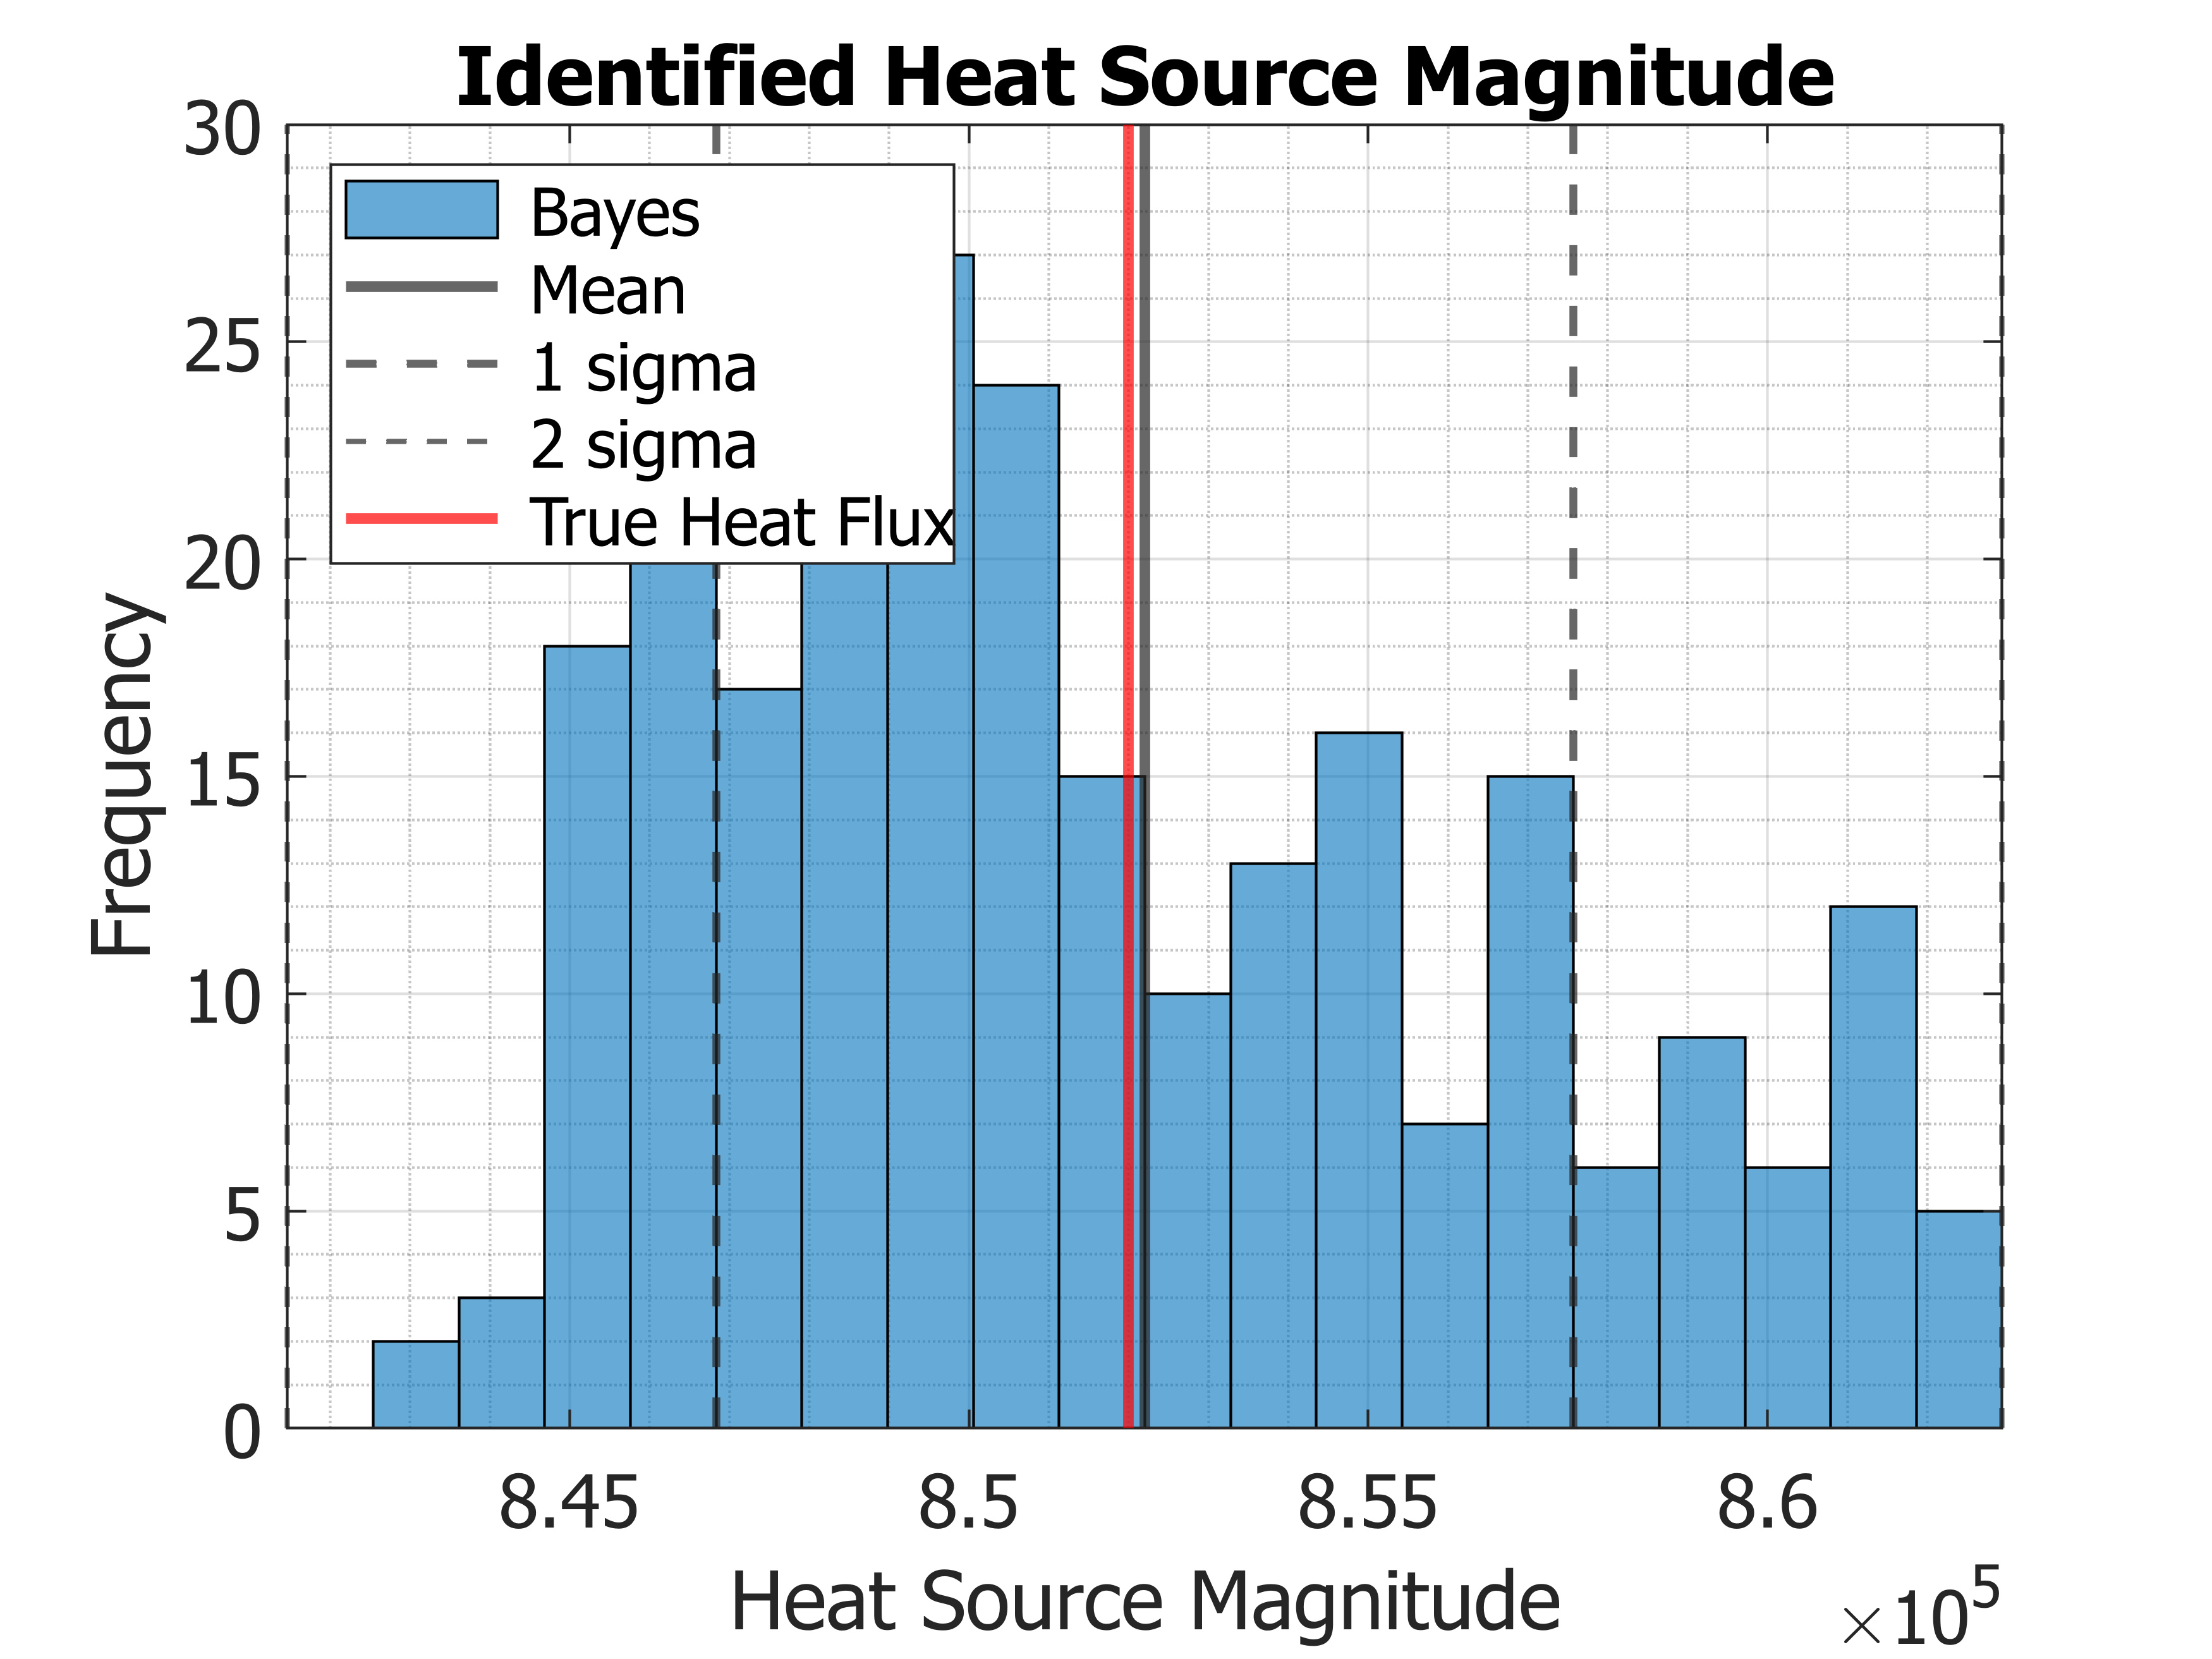

In [34]:
qbcs_result_lower = qbcs_result_statistics_mean - 2 * qbcs_result_statistics_std;
qbcs_result_upper = qbcs_result_statistics_mean + 2 * qbcs_result_statistics_std;
num_bins = 20;  % Set number of bins as desired
bin_edges = linspace(qbcs_result_lower, qbcs_result_upper, num_bins + 1);

figure;
set(gcf, 'WindowState', 'maximized');
histogram(qbcs_result_statistics, 'BinEdges', bin_edges, 'DisplayName', ' Bayes')
% Plot mean and standard deviation lines
xline(qbcs_result_statistics_mean, 'LineWidth', 2, 'DisplayName', ' Mean');
xline(qbcs_result_statistics_mean + qbcs_result_statistics_std, '--', 'LineWidth', 1.5, 'DisplayName', ' 1 sigma');
xline(qbcs_result_statistics_mean - qbcs_result_statistics_std, '--', 'LineWidth', 1.5, 'HandleVisibility', 'off');
xline(qbcs_result_statistics_mean + 2 * qbcs_result_statistics_std, '--', 'LineWidth', 1.0, 'DisplayName', ' 2 sigma');
xline(qbcs_result_statistics_mean - 2 * qbcs_result_statistics_std, '--', 'LineWidth', 1.0, 'HandleVisibility', 'off');
xline(heat_flux_source, 'r', 'LineWidth', 2, 'DisplayName', ' True Heat Flux');

title('Identified Heat Source Magnitude');
xlabel('Heat Source Magnitude')
ylabel('Frequency')
set(gca, 'FontSize', fontsize, 'FontName', 'Times')
grid on
grid minor
xlim([qbcs_result_lower, qbcs_result_upper])
legend('show','location','northwest')